In [2]:
import pandas as pd
from descriptor_gen import DescriptorGen
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score, silhouette_samples
from tqdm import tqdm
import numpy as np
import seaborn as sns
from sklearn.manifold import TSNE
import mols2grid
import matplotlib.cm as cm

Enable Pandas [progress_apply](https://towardsdatascience.com/progress-bars-in-python-and-pandas-f81954d33bae)

In [3]:
tqdm.pandas()

Set up Seaborn plot aesthetics

In [4]:
sns.set()
sns.set(rc={'figure.figsize': (10, 10)})
sns.set_style('whitegrid')
sns.set_context('talk')

Read the input data

In [5]:
smiles_url = "https://raw.githubusercontent.com/PatWalters/datafiles/main/cluster_test.smi"
df = pd.read_csv(smiles_url,sep=" ",names=["SMILES","Name"])

Add molecular fingerprints to the dataframe

In [6]:
dg = DescriptorGen(desc_type="fp")
df['desc'] = df.SMILES.progress_apply(dg.from_smiles)

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 735/735 [00:00<00:00, 2375.17it/s]


Convert the fingerprints to an X matrix to make sklearn happy

In [7]:
X = np.stack(df.desc)

Clustering with k-means only requires a few lines of code

In [8]:
num_clusters = 8
km = KMeans(n_clusters=num_clusters,random_state=42)
km.fit(X)
cluster_list = km.predict(X)

Plot the cluster populations

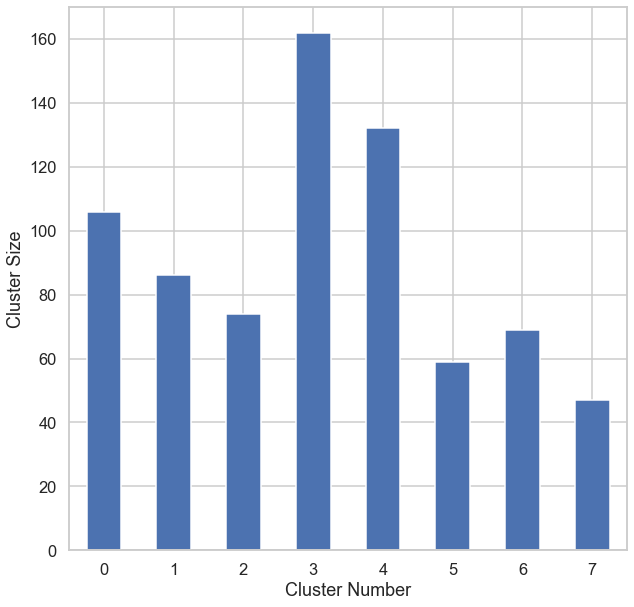

In [9]:
ax = pd.Series(cluster_list).value_counts().sort_index().plot(kind="bar")
ax.set_xlabel("Cluster Number")
ax.set_ylabel("Cluster Size")
ax.tick_params(axis='x', rotation=0)

One potential drawback of k-means clustering is that it requires you to specify the number of clusters.  One means of determining the optimal number of clusters is by minimizing the silhouette score. 

Silhouette Score =  $\frac{(a-b)}{max(a,b)}$ where **a** is the average intracluster distance and **b** is the average intercluster distance.

In [10]:
cluster_range = range(5,25)
score_list = []
for k in tqdm(cluster_range):
    km = KMeans(n_clusters=k,random_state=42)
    cluster_labels = km.fit_predict(X)
    score = silhouette_score(X,cluster_labels)
    score_list.append([k,score])

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:08<00:00,  2.47it/s]


Put the silhouette scores into a dataframe

In [11]:
score_df = pd.DataFrame(score_list,columns=["K","Silhoutte Score"])
score_df.head()

,K,Silhoutte Score
0,5,0.311763
1,6,0.332428
2,7,0.323101
3,8,0.268274
4,9,0.277267


Plot the silhoustte scores as a function of the number of clusters

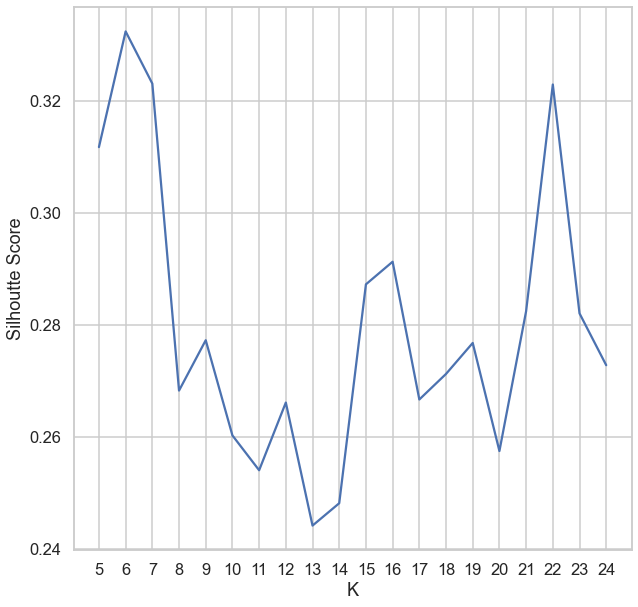

In [12]:
ax = sns.lineplot(x="K",y="Silhoutte Score",data=score_df)
ax.set_xticks(cluster_range);

In the figure above the minimum sihouette score is observed with 13 clusters.  Let's run KMeans with num_clusters = 13. 

In [13]:
num_clusters = 13
km_opt = KMeans(n_clusters=num_clusters)
clusters_opt = km_opt.fit_predict(X)

Routine to plot a silhouette plot

In [14]:
def silhouette_plot(X,cluster_labels):
    """
    Adapted from https://scikit-learn.org/stable/auto_examples/cluster/plot_kmeans_silhouette_analysis.html
    """
    sns.set_style('whitegrid')
    sample_df = pd.DataFrame(silhouette_samples(X,cluster_labels),columns=["Silhouette"])
    sample_df['Cluster'] = cluster_labels
    n_clusters = max(cluster_labels+1)
    color_list = [cm.nipy_spectral(float(i) / n_clusters) for i in range(0,n_clusters)]
    ax = sns.scatterplot()
    ax.set_xlim([-0.1, 1])
    ax.set_ylim([0, len(X) + (n_clusters + 1) * 10])
    silhouette_avg = silhouette_score(X, cluster_labels)
    y_lower = 10
    unique_cluster_ids = sorted(sample_df.Cluster.unique())
    for i in unique_cluster_ids:
        cluster_df = sample_df.query('Cluster == @i')
        cluster_size = len(cluster_df)
        y_upper = y_lower + cluster_size
        ith_cluster_silhouette_values = cluster_df.sort_values("Silhouette").Silhouette.values
        color = color_list[i]
        ax.fill_betweenx(np.arange(y_lower, y_upper),
                    0, ith_cluster_silhouette_values,
                    facecolor=color, edgecolor=color, alpha=0.7)
        ax.text(-0.05, y_lower + 0.5 * cluster_size, str(i),fontsize="small")
        y_lower = y_upper + 10
    ax.axvline(silhouette_avg,color="red",ls="--")
    ax.set_xlabel("Silhouette Score")
    ax.set_ylabel("Cluster")
    ax.set(yticklabels=[]) 
    ax.yaxis.grid(False) 

Plot a sihouette plot for the clustering above

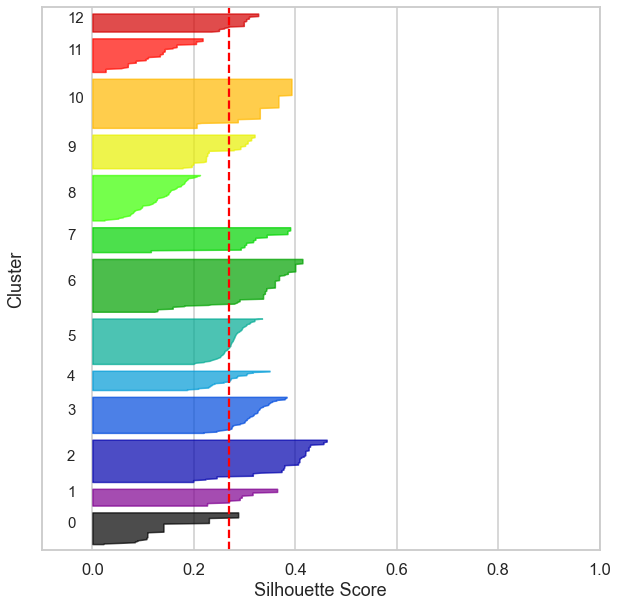

In [15]:
silhouette_plot(X,clusters_opt)

Make a TSNE plot of the clustering

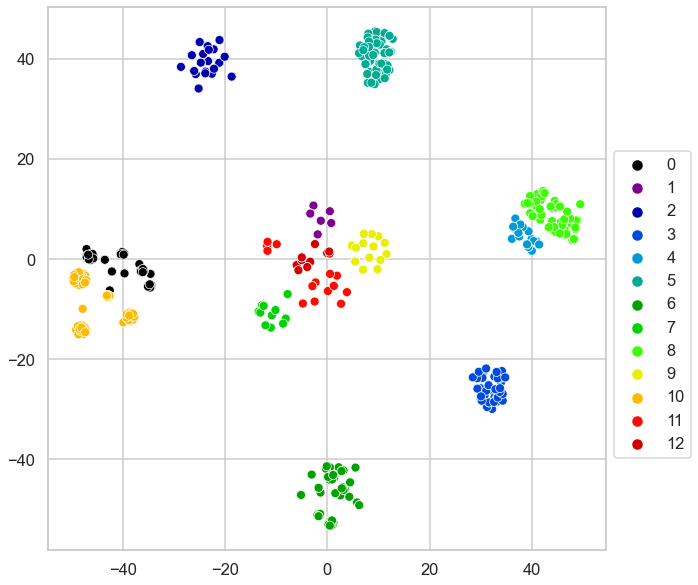

In [16]:
tsne = TSNE(n_components=2)
crds = tsne.fit_transform(X,clusters_opt)
color_list = [cm.nipy_spectral(float(i) / num_clusters) for i in range(0,num_clusters)]
ax = sns.scatterplot(x=crds[:,0],y=crds[:,1],hue=clusters_opt,palette=color_list,legend=True)
ax.legend(loc='upper left', bbox_to_anchor=(1.00, 0.75), ncol=1);

Add a cluster column to our input dataframe

In [17]:
opt_cluster_df = df.copy()
opt_cluster_df['Cluster'] = clusters_opt

Display structures of the cluster members

In [19]:
cluster_id = 1
cols = ["SMILES","Name","Cluster"]
display_df = opt_cluster_df[cols].query("Cluster == @cluster_id")
mols2grid.display(display_df,subset=["img"],n_cols=3,size=(320,240))